In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import umap
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn.metrics import adjusted_rand_score, silhouette_score
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy.io import loadmat
umist = loadmat('data/umist_cropped.mat')
dataset = umist['facedat']
umist_data = pd.read_csv('data/umist_cropped.csv')

In [3]:
# Combine all the images of all the persons into a single list
data_lst = []

for i in range(20):
    person_imgs = dataset[0][i]
    for j in range(person_imgs.shape[2]):
        img = person_imgs[:, :, j]
        img_flat = img.flatten()
        data_lst.append(np.append(img_flat, i))

In [4]:
# Convert into DataFrame
df_columns = [f'pixel_{i}' for i in range(112*92)] + ['label']
df = pd.DataFrame(data_lst, columns=df_columns)
df.head(5)

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0      233      234      234      233      234      232      232      168   
1      234      234      234      234      233      232      202       98   
2      234      234      234      234      233      230      225      109   
3      234      234      234      234      234      234      234      232   
4      234      234      234      234      234      234      234      234   

   pixel_8  pixel_9  ...  pixel_10295  pixel_10296  pixel_10297  pixel_10298  \
0       99       78  ...          154          151          147          143   
1       79       77  ...          154          150          147          141   
2       85       84  ...          174          168          164          157   
3      229      205  ...          168          162          157          155   
4      229      211  ...          176          170          164          162   

   pixel_10299  pixel_10300  pixel_10301  pixel_10302  pixel_10303  label  
0          140          141          141          140          136      0  
1          140          137          138          137          137      0  
2          152          151          148          145          145      0  
3          150          144          144          142          143      0  
4          157          152          150          148          148      0  

[5 rows x 10305 columns]

In [5]:
# Remove duplicate rows
df = df.drop_duplicates()

In [6]:
# Convert into numpy array
data = df.to_numpy()

In [7]:
X = data[:, :-1]
y = data[:, -1]
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (565, 10304)
y.shape: (565,)


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
# Dataset is imbalanced, use StratifiedShuffleSplit to split the dataset
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=123)
for train_idx, val_test_idx in sss.split(X, y):
    X_train, X_val_test = X[train_idx], X[val_test_idx]
    y_train, y_val_test = y[train_idx], y[val_test_idx]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=123)
for val_idx, test_idx in sss.split(X_val_test, y_val_test):
    X_val, X_test = X_val_test[val_idx], X_val_test[test_idx]
    y_val, y_test = y_val_test[val_idx], y_val_test[test_idx]

In [9]:
# 1. Preprocess the Data (Assume X is loaded)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)

In [10]:
# 2. Apply PCA to Retain 99% Variance
pca = PCA(n_components=0.99)  # Automatically chooses components to retain 99% variance
X_pca = pca.fit_transform(X_scaled)
print(f"Number of components chosen by PCA: {X_pca.shape[1]}")

Number of components chosen by PCA: 217


In [11]:
# 3. Apply UMAP on the PCA-Reduced Data
umap_reducer = umap.UMAP(n_components=2, random_state=123)  # Project to 2D
X_umap = umap_reducer.fit_transform(X_pca)

In [12]:
# Initialize Agglomerative Clustering
expected_cluster = 20
agg_cluster = AgglomerativeClustering(n_clusters=expected_cluster, linkage='ward')  # Adjust `n_clusters` as needed
# Fit the model and predict cluster labels
cluster_labels = agg_cluster.fit_predict(X_umap)

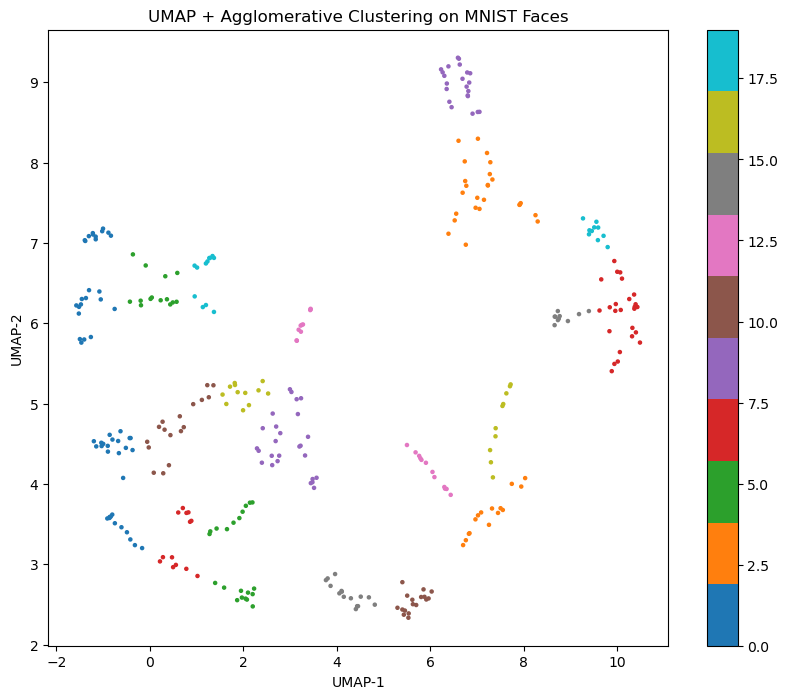

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("UMAP + Agglomerative Clustering on MNIST Faces")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [14]:
print(Counter(cluster_labels))

Counter({0: 28, 8: 26, 3: 25, 1: 25, 7: 25, 9: 22, 4: 21, 10: 17, 11: 17, 14: 15, 2: 15, 5: 14, 6: 13, 19: 12, 13: 12, 16: 12, 17: 10, 18: 10, 15: 10, 12: 10})


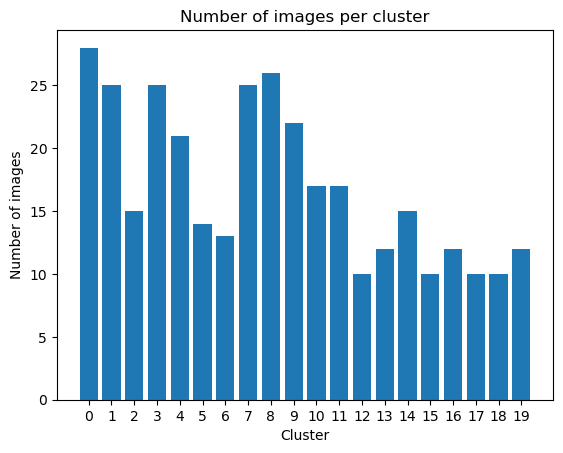

In [16]:
plt.bar(range(expected_cluster), np.bincount(cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(expected_cluster))
plt.show()

In [17]:
# Compare clusters with ground-truth labels
ari_score = adjusted_rand_score(y_train.flatten(), cluster_labels)
print(f"Adjusted Rand Index: {ari_score:.2f}")

Adjusted Rand Index: 0.33


In [18]:
# Measure the quality of clustering (higher is better for silhouette score)
silhouette = silhouette_score(X_umap, cluster_labels)
print(f"Silhouette Score: {silhouette:.2f}")

Silhouette Score: 0.54


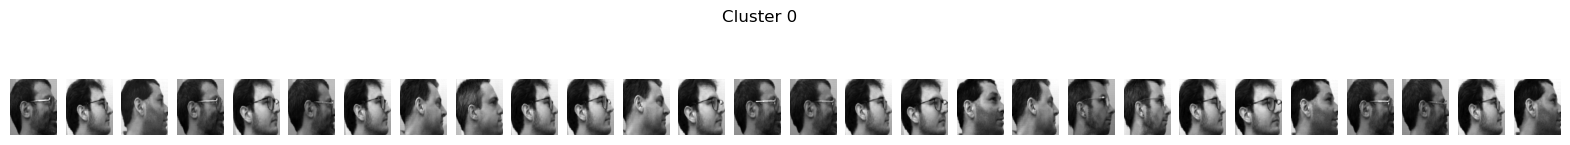

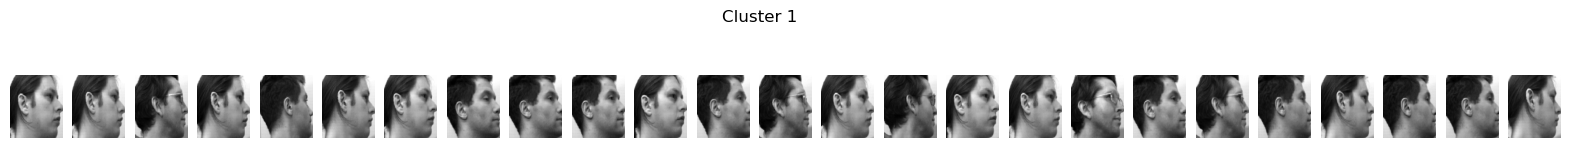

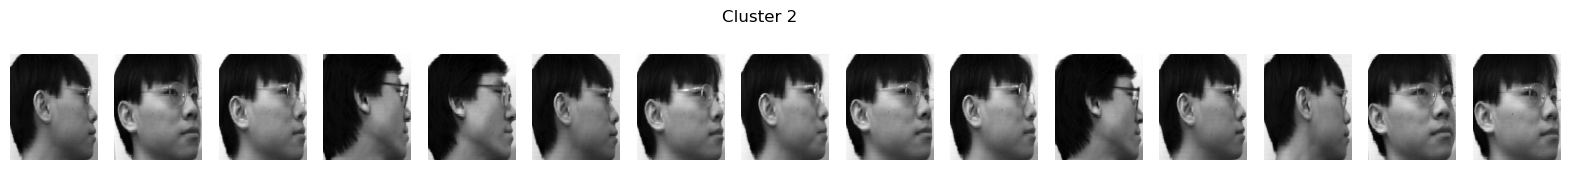

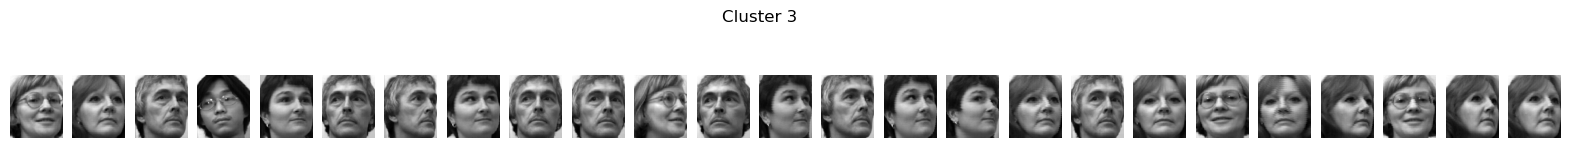

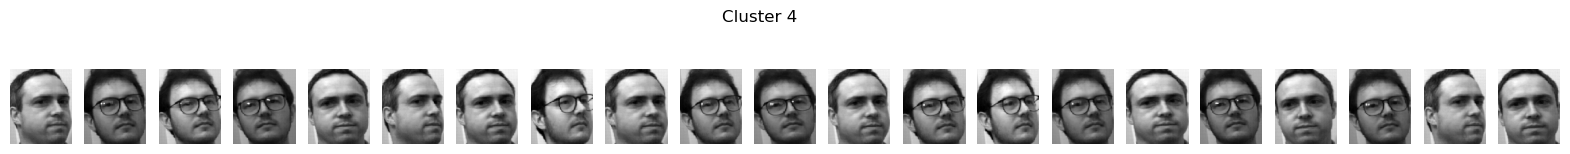

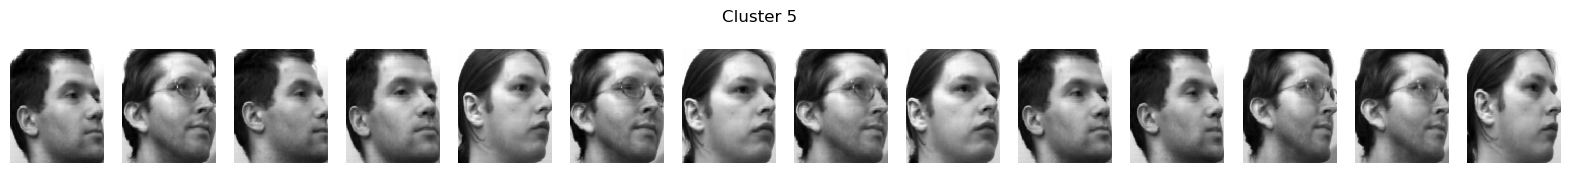

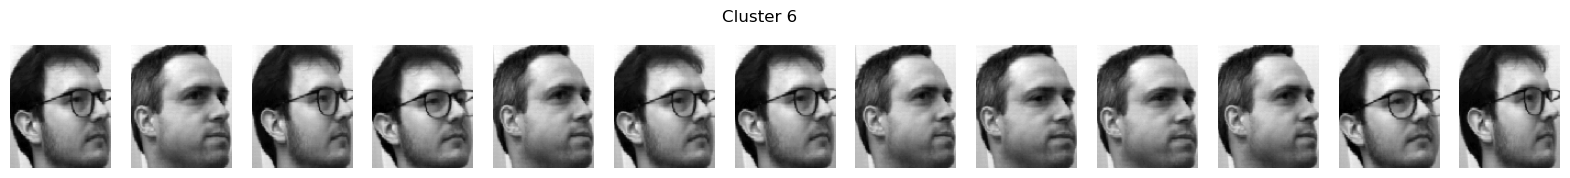

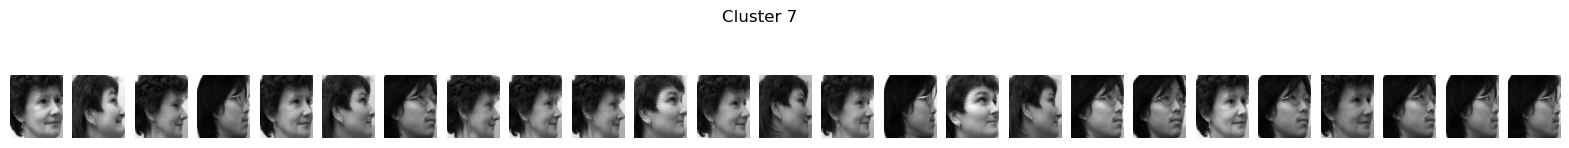

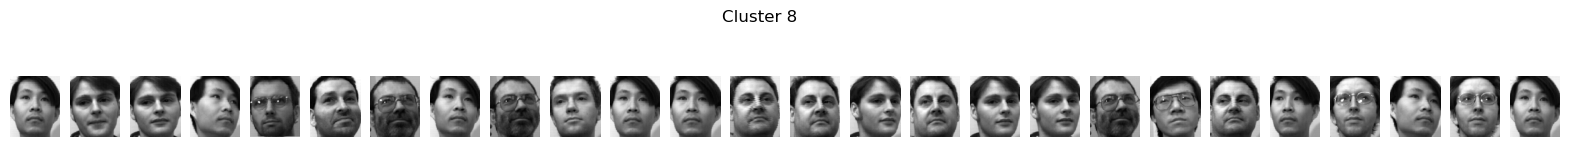

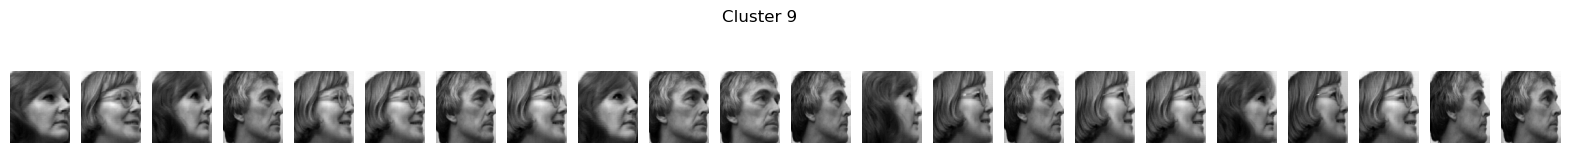

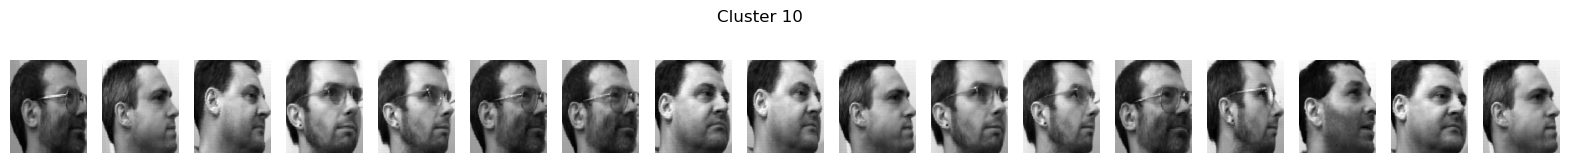

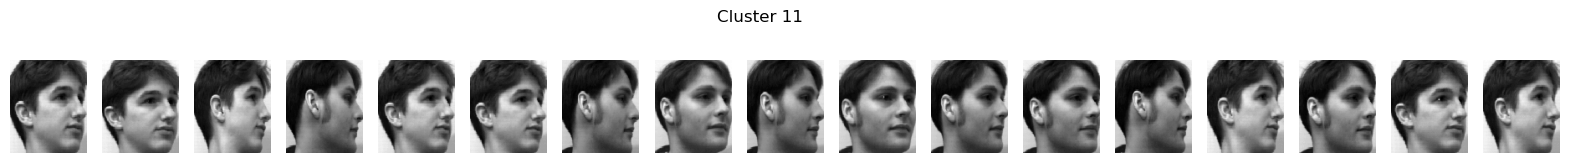

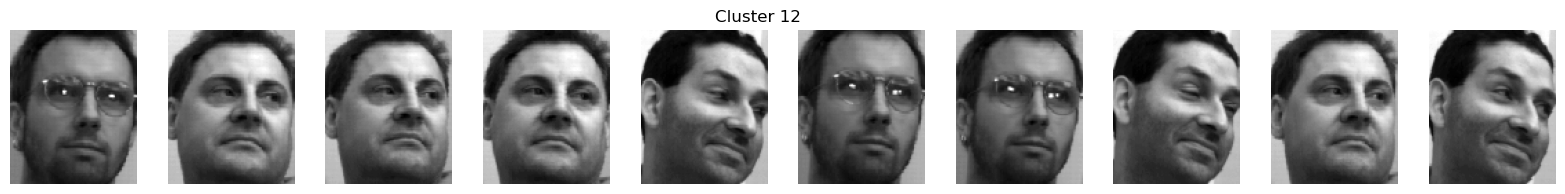

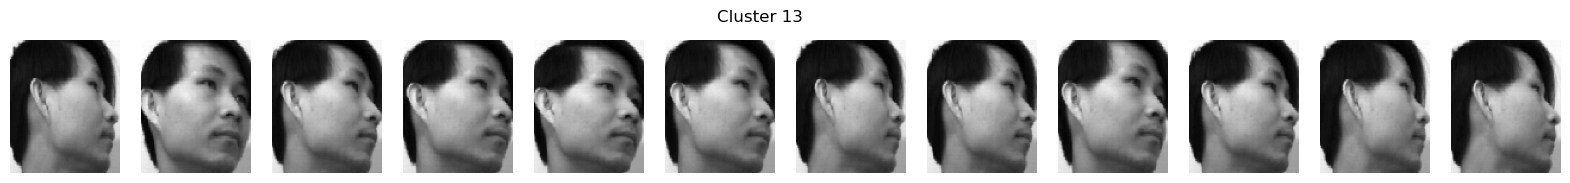

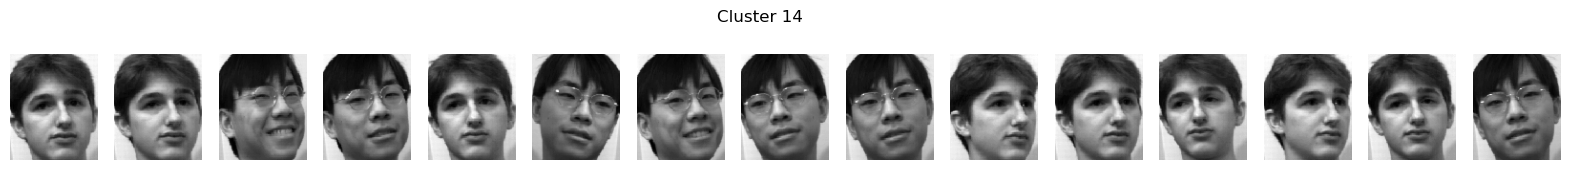

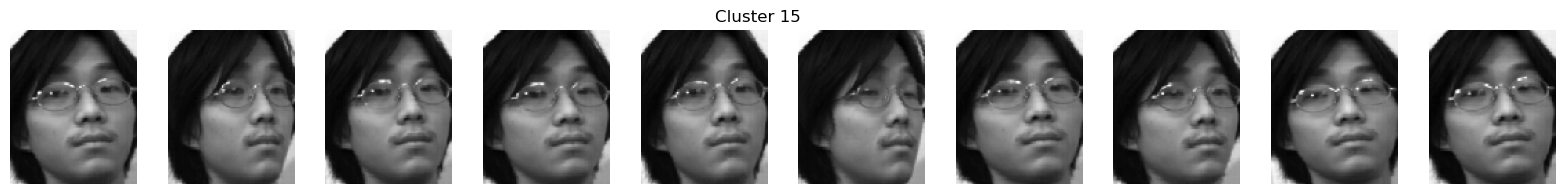

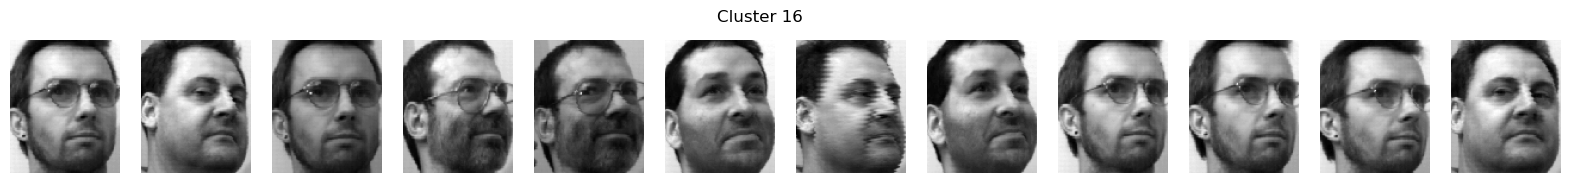

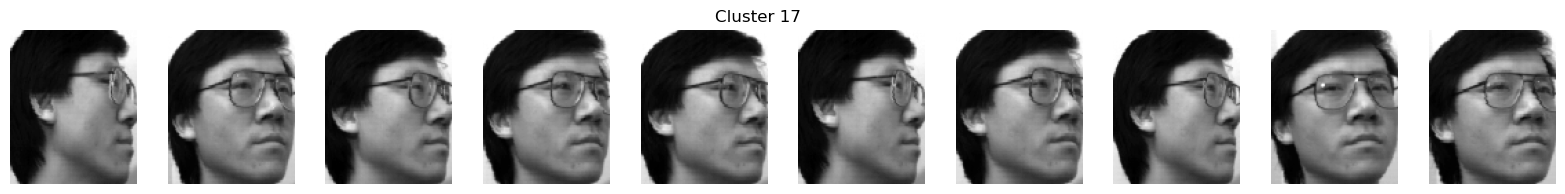

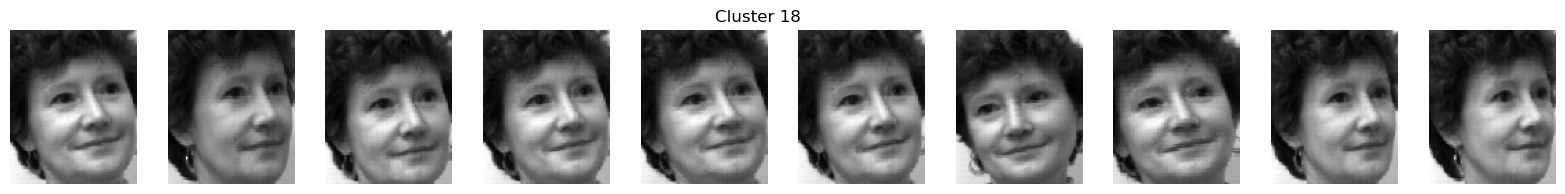

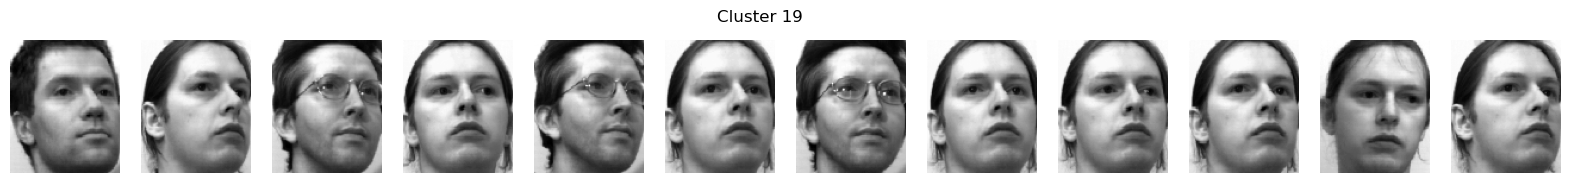

In [19]:
def plot_result(cluster_num):
    for cluster_id in range(cluster_num+1):
        # Get the indices of images in the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        # Determine the number of images to plot
        num_images = len(cluster_indices)
        
        if num_images > 0:
            fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
            
            # Handle the case where there is only one image
            if num_images == 1:
                axes = [axes]  # Convert single axis to a list for consistency
            
            for i in range(num_images):
                # Get the image index
                image_index = cluster_indices[i]
                
                # Get the image data
                image_data = X_train[image_index]
                
                # Reshape the image data
                image_data = image_data.reshape(112, 92)
                
                # Plot the image
                axes[i].imshow(image_data, cmap='gray')
                axes[i].axis('off')
            
            plt.suptitle(f"Cluster {cluster_id}")
            plt.show()
plot_result(expected_cluster)

Average linkage and euclidean metric: 

Number of clusters: 20
Silhouette Score: 0.5371643900871277


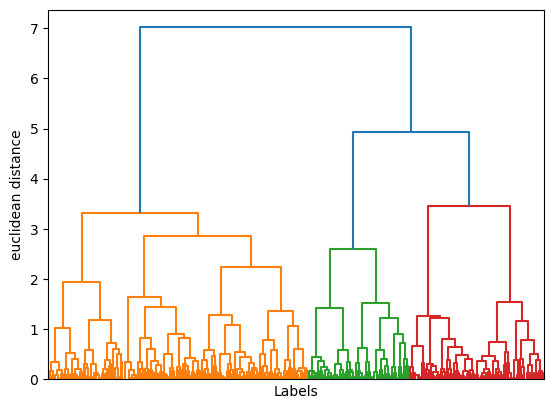

Average linkage and minkowski metric: 

Number of clusters: 20
Silhouette Score: 0.5433237755527038


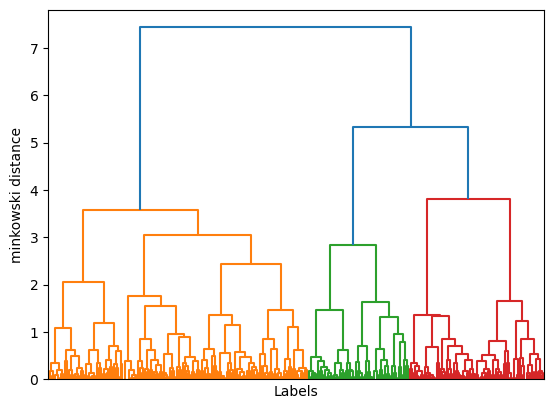

Average linkage and cosine metric: 

Number of clusters: 20
Silhouette Score: 0.7085073590278625


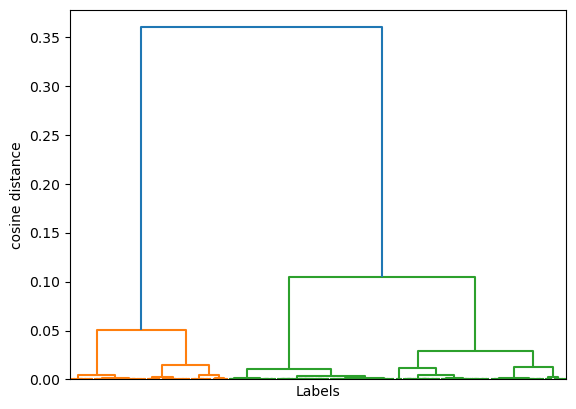

Average linkage and cityblock metric: 

Number of clusters: 20
Silhouette Score: 0.537868031894521


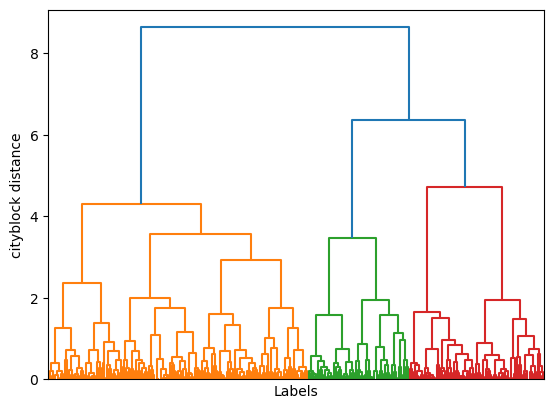

In [20]:
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

metrics_list = ['euclidean', 'minkowski', 'cosine', 'cityblock']       
                
results = {}
square_distances_matrix = []
clusters_res = []

for m in metrics_list:
    print(f'Average linkage and {m} metric: \n')
    
    if m == 'minkowski':
        Y = pdist(X_umap, metric=m, p=1.5)
    else:
        Y = pdist(X_umap, metric=m)
        
    Z = linkage(Y, method='average')
    clusters = fcluster(Z, 20, criterion='maxclust')
    dendrogram(Z, no_labels= True)
    # Check the number of clusters
    num_clusters = len(set(clusters))
    clusters_res.append(clusters)
    print(f'Number of clusters: {num_clusters}')
    silhouette = metrics.silhouette_score(X_umap, clusters, metric=m)
    print(f'Silhouette Score: {silhouette}')
    plt.xlabel("Labels")
    plt.ylabel(f'{m} distance')
    plt.show()

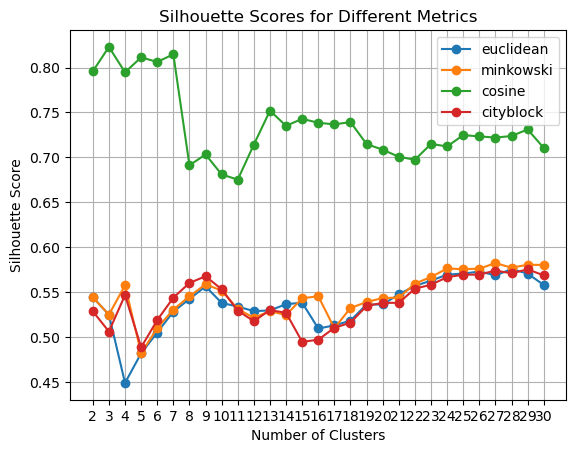

In [21]:
max_clusters = 30  # Maximum number of clusters to test
for metric in metrics_list:
    silhouette_scores = []
    
    # Iterate through the possible number of clusters
    for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
        # Compute pairwise distances
        if metric == 'minkowski':
            Y = pdist(X_umap, metric=metric, p=1.5)
        else:
            Y = pdist(X_umap, metric=metric)
        
        if metric in ['euclidean']:
            Z = linkage(Y, method='ward')
        else:
            Z = linkage(Y, method='average')

        # Create flat clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')

        # Check the number of clusters formed
        num_clusters_formed = len(set(clusters))
        
        # Ensure that the number of clusters is valid
        if num_clusters_formed > 1:
            # Calculate silhouette score
            silhouette = metrics.silhouette_score(X_umap, clusters, metric=metric)
            silhouette_scores.append(silhouette)
        else:
            silhouette_scores.append(-1)  # Append a negative score or None if not valid

    # Store results for the current metric
    results[metric] = silhouette_scores

    # Plotting
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)

# Plotting
plt.title("Silhouette Scores for Different Metrics")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, max_clusters + 1))
plt.legend()
plt.grid()
plt.show()

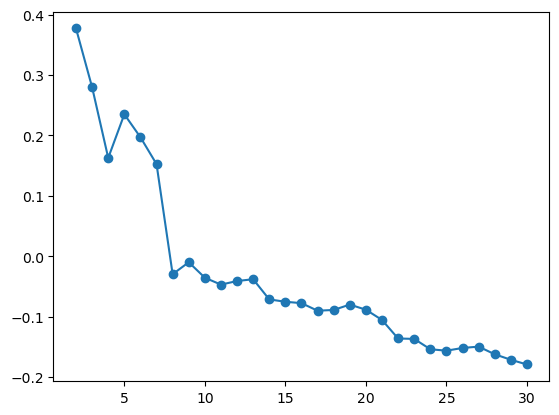

In [22]:
silhouette_scores = []
# Iterate through the possible number of clusters
for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
    # Compute pairwise distances
    Y = pdist(X_umap, metric='cosine')
    # Perform hierarchical clustering using linkage
    Z = linkage(Y, method='average')
    # Create flat clusters
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    # Check the number of clusters formed
    num_clusters_formed = len(set(clusters))
    # Ensure that the number of clusters is valid
    if num_clusters_formed > 1:
        # Calculate silhouette score
        silhouette = metrics.silhouette_score(X_umap, clusters, metric=metric)
        silhouette_scores.append(silhouette)
    else:
        silhouette_scores.append(-1)  # Append a negative score or None if not valid

# Plotting
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)
plt.show()

In [23]:
from scipy.cluster.hierarchy import fcluster
# Set a cutoff distance
cutoff_distance = 15  # Adjust this based on the dendrogram
# Get cluster labels
cluster_labels = fcluster(Z , cutoff_distance, criterion='maxclust')
# Print or analyze the clusters
print("Cluster labels for each image:", cluster_labels)
print(np.unique(cluster_labels))

Cluster labels for each image: [ 6  2  8  9  9 11 12  2  4  8 11  8  6 14  7  1 12 11  2  4  6  8  2  2
  9  2 12  9  7  9  8 11  2  1 12  9  2  7  3  8 12  8  2  9 14  9  9  2
 12  5  8 11  7 12  5  3  7  2 12  9  1  1  8 12  7  2  6  2  9  4 12  8
 13 13 13  9  9  4  7  7  1 13  9 13 15  7 13  9  2 13  2  8  7  7 12 11
  5 13  9  4  9  4  7  5  4  2 12 13  5  1  8 12  8  9  3  8 10  3  9  8
  1  4 12 13 13 13  8 11  9  3 13  9 12  4  9  8  9  7 13 10  4  2  8  7
  6  7 11  2 12  7  9  7  8 13  7 12  8  4 11  9 11  2  1 12 11  1  5  9
 11  8  7 11  5 13  3  9 15  5  4  7  5  4  8  5  4 11 13 13 13  7 12  1
  1 14  8  9  2 12 13  2 13  2  6  2 13  1  9  1  9 13  8 13  9  3  3 15
 10 14  7  6 12  3 13  4  2 13  7  7  1  7 14 12 15  4  2 12  7  8 13 11
  8  8  9  6 10 10  1  9 11  5 11  9  4  9  2  6 13  9  6  8 13  1  7  2
 11  4 13  2 12 12  9 12  2 14 12  7 12 12  7 12  2  5  2 13 11 15  2  8
  3 11  9  2 13  7  7 11 15 11 13 12 13 15  9  8  5 15  9  8  5  9 15  4
  4  2  8 13  9  9 1

In [24]:
from collections import Counter
print(Counter(cluster_labels))

Counter({9: 45, 13: 37, 2: 36, 8: 36, 12: 34, 7: 33, 11: 26, 4: 20, 1: 16, 5: 15, 6: 11, 3: 10, 15: 9, 14: 6, 10: 5})


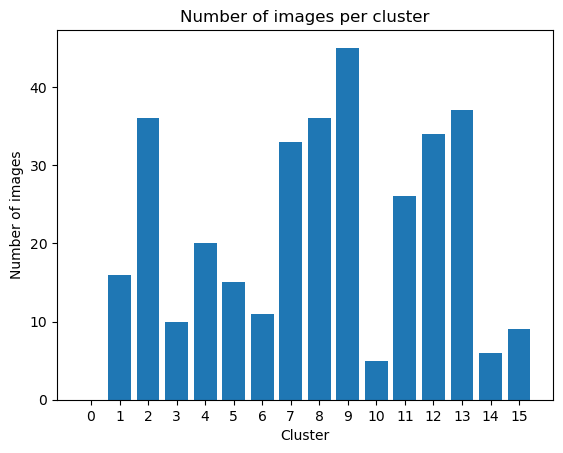

In [25]:
plt.bar(range(cutoff_distance+1), np.bincount(cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(cutoff_distance+1))
plt.show()

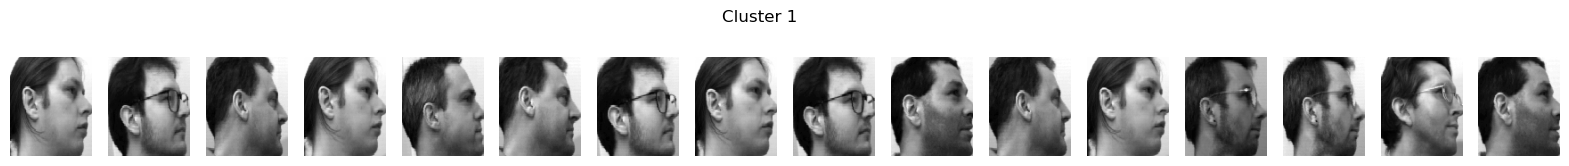

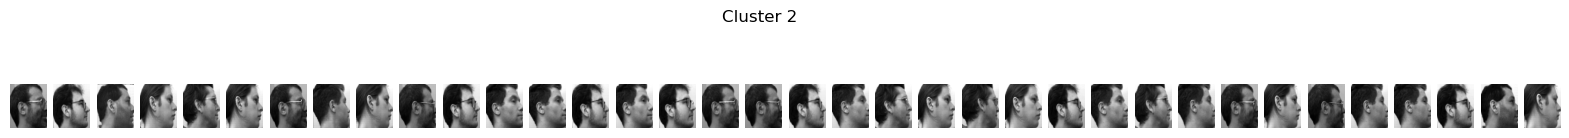

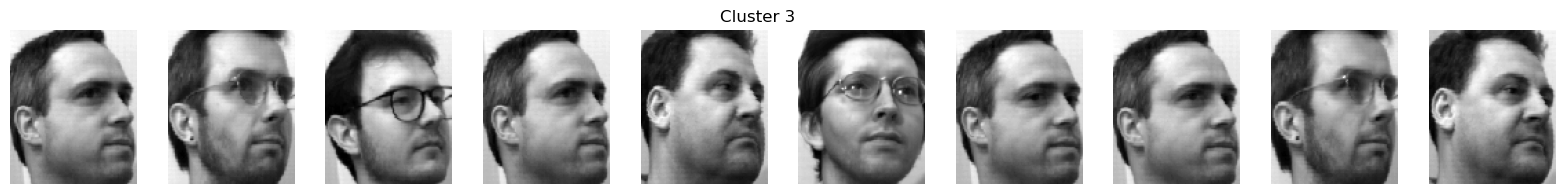

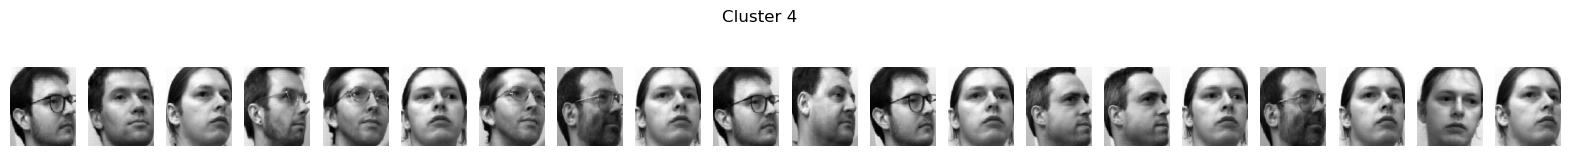

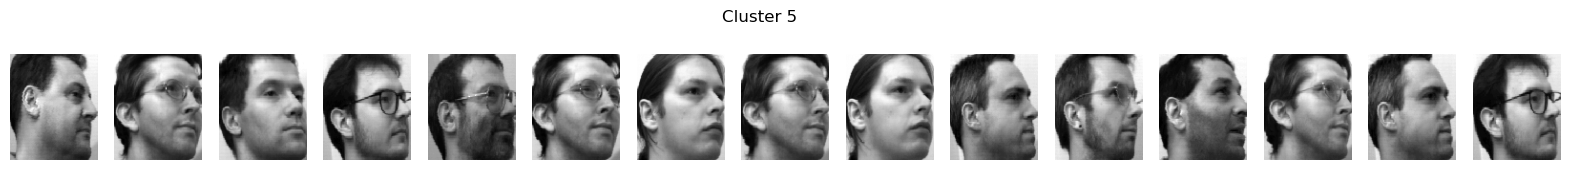

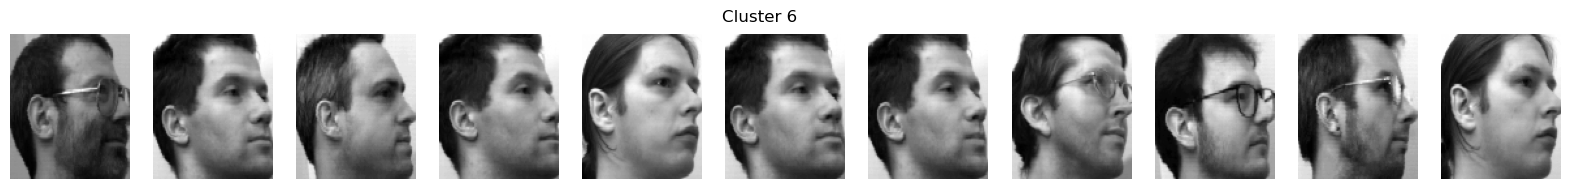

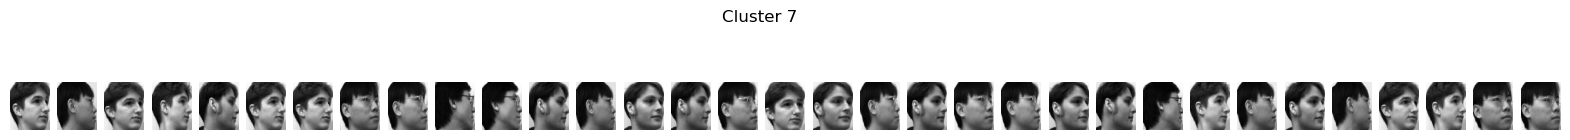

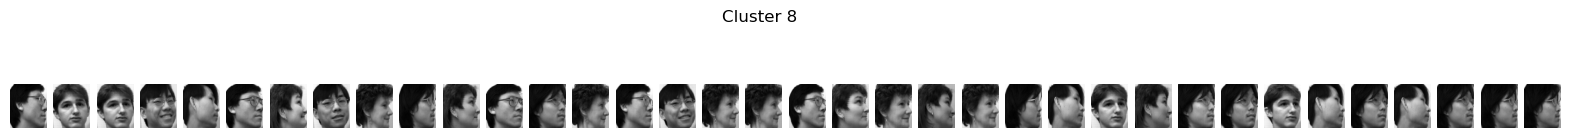

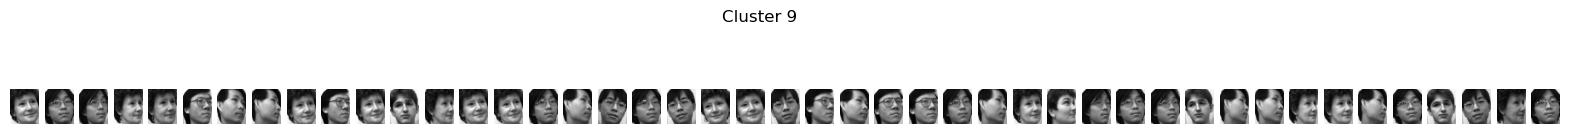

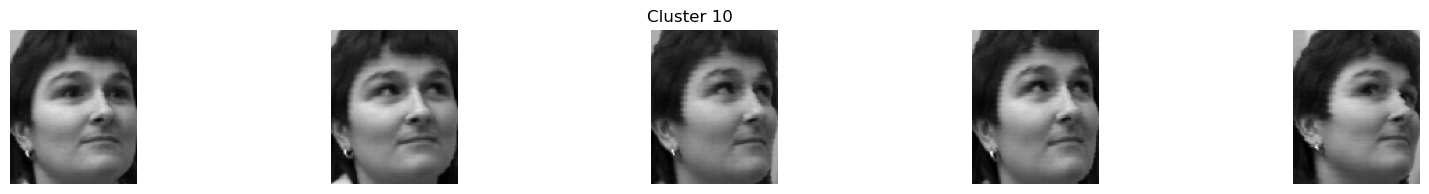

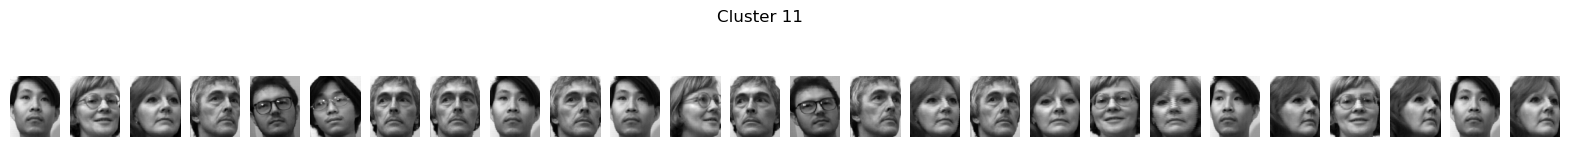

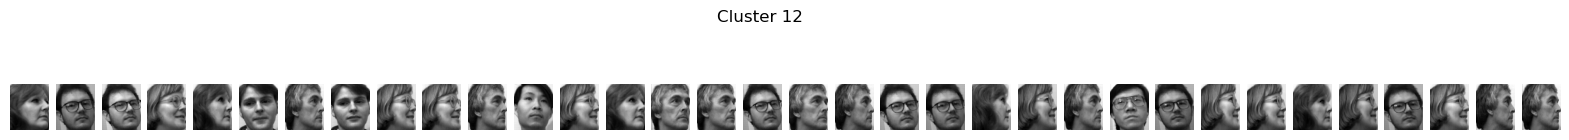

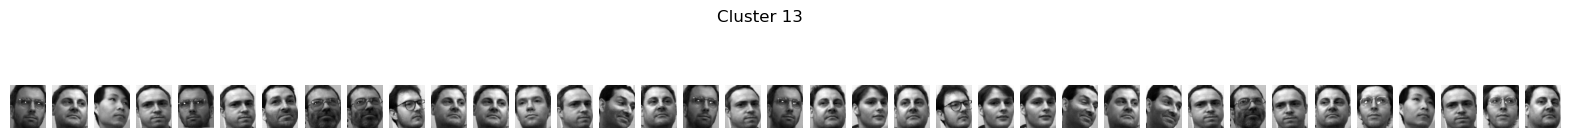

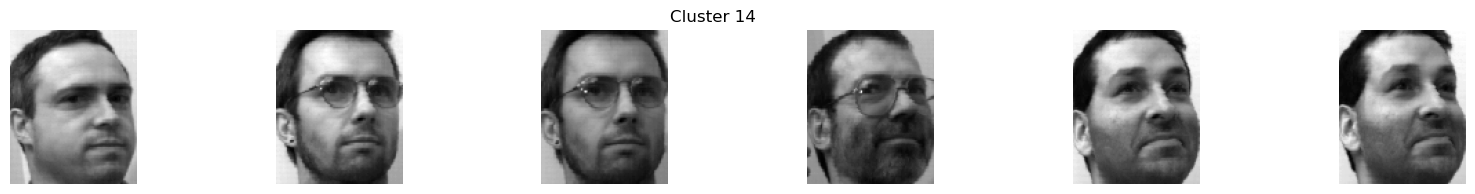

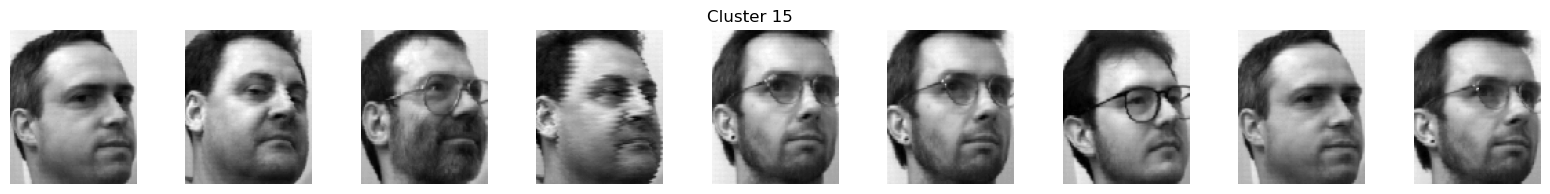

In [26]:
plot_result(cutoff_distance)